In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
from PIL import Image
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize,Pad


from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from deep_learning_project.data_preprocess import SphericalImageRotationDataset,extract_labels_from_filename,create_transformation_matrix,vector_from_rotation,generate_pairs_with_labels,plot_image_pair_with_label
from deep_learning_project.Rotation_estimation_paper_architecture import TransformerDecoder,SiameseUNet,ExtremeRotationEstimator,QuaternionLoss

In [2]:
image_dir = "SphericalImages2" 
image_paths = glob.glob(os.path.join(image_dir, "*.png"))

pairs, labels = generate_pairs_with_labels(image_paths)
dataset = SphericalImageRotationDataset(pairs, labels)


In [3]:
batch_size = 32
# Assuming `dataset` is your complete dataset
dataset_size = len(dataset)

# Calculate the sizes for train and validation splits
val_size = int(0.2 * dataset_size)  # 20% for validation
train_size = dataset_size - val_size  # Remaining 80% for training

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for both splits
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Total Dataset Size: {dataset_size}")
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")


Total Dataset Size: 95266
Training Dataset Size: 76213
Validation Dataset Size: 19053


In [ ]:
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# dataloader

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



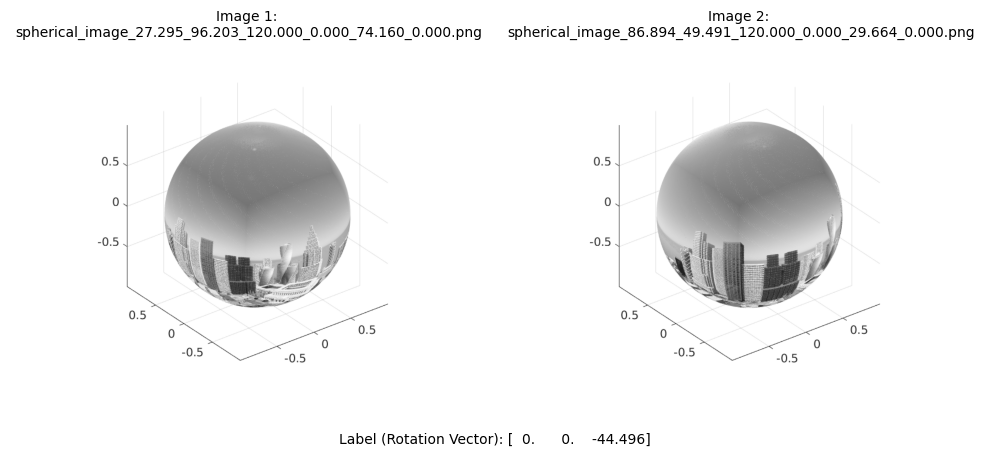

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



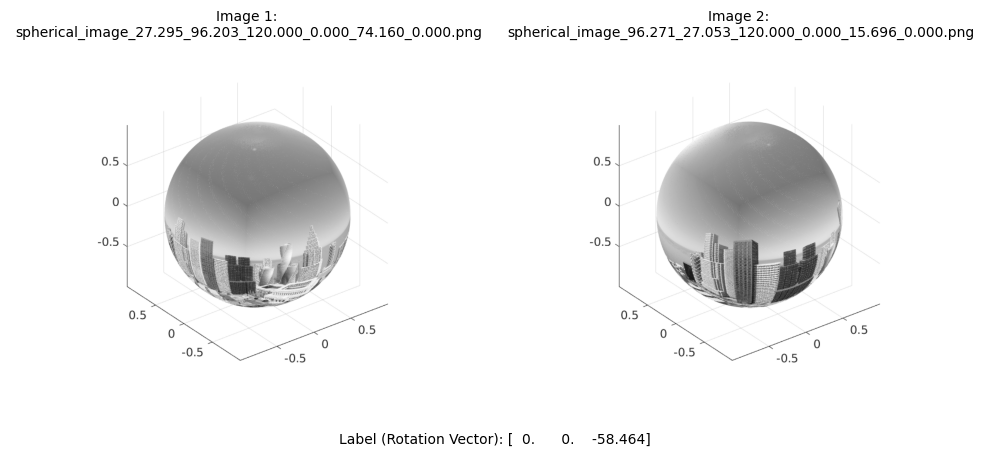

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



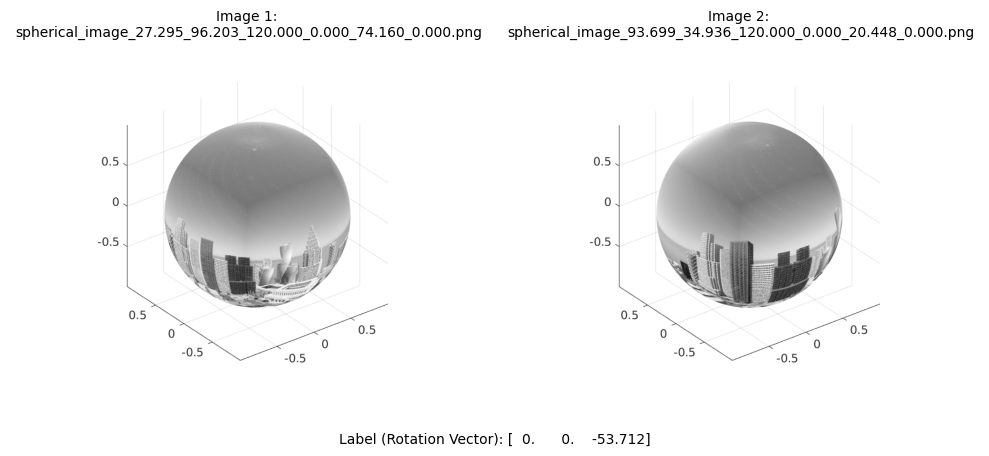

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



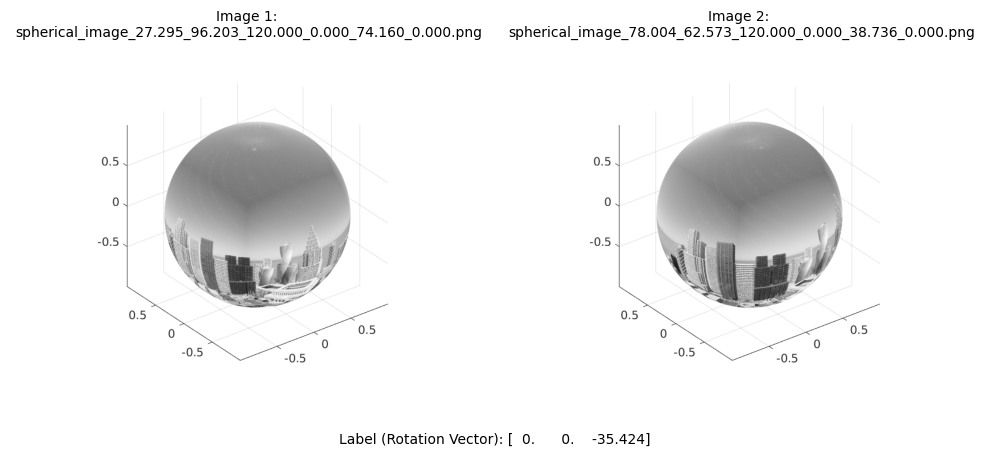

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



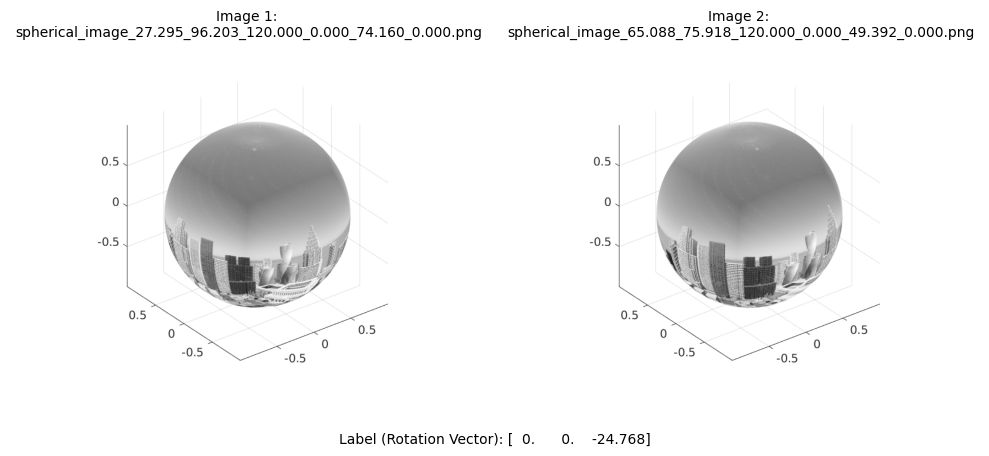

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



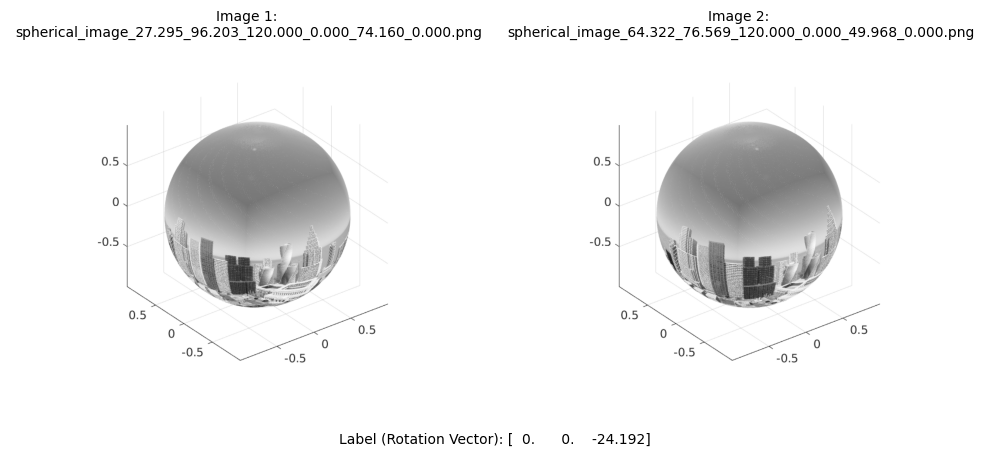

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



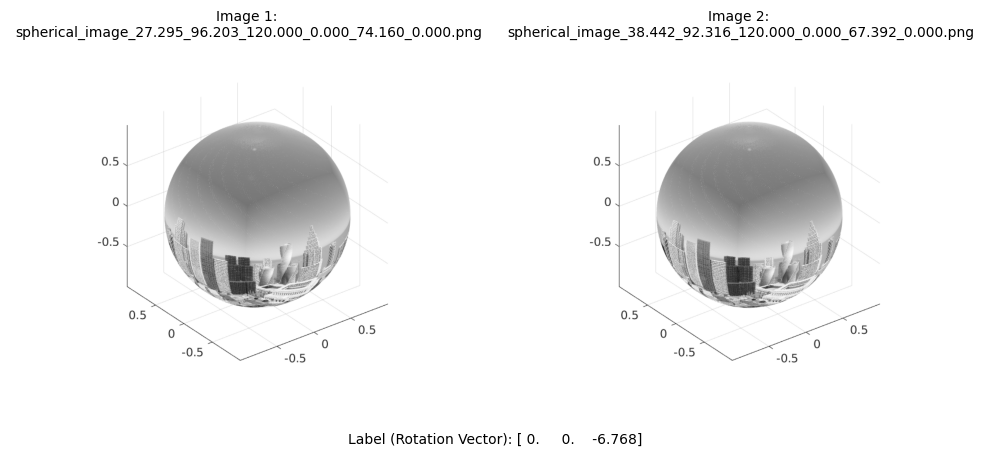

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



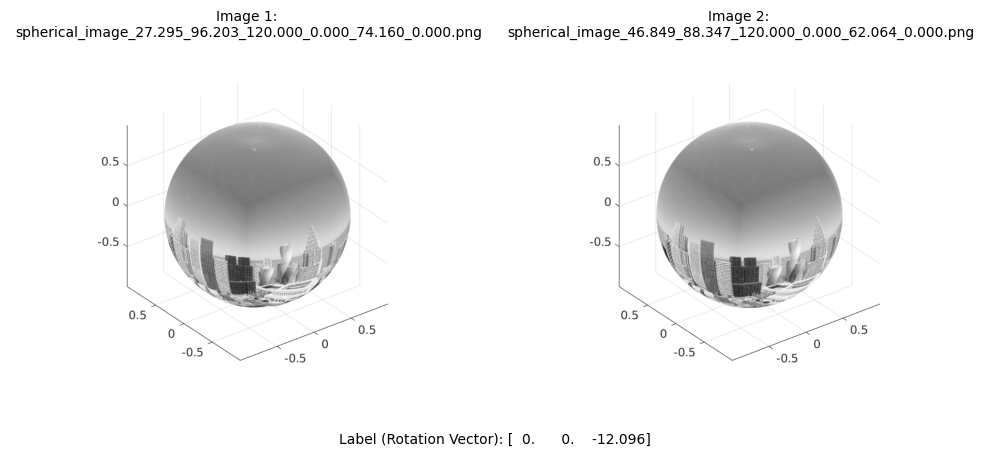

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



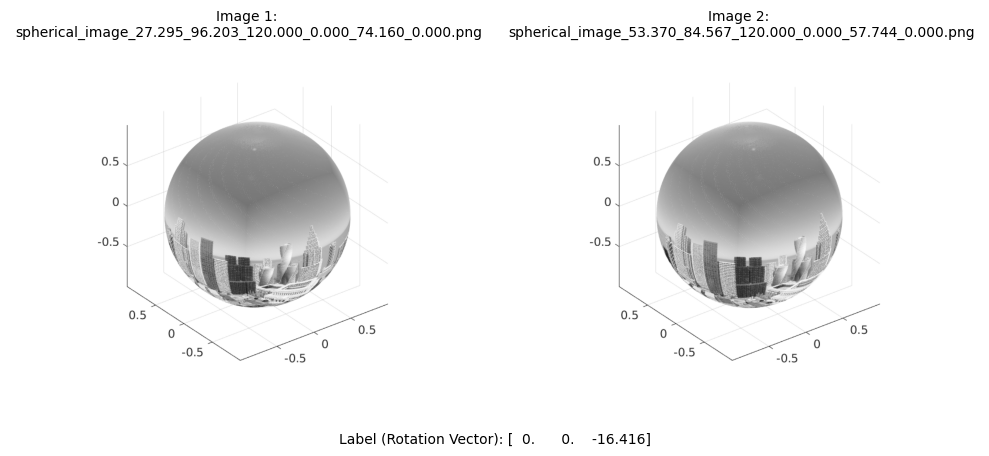

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



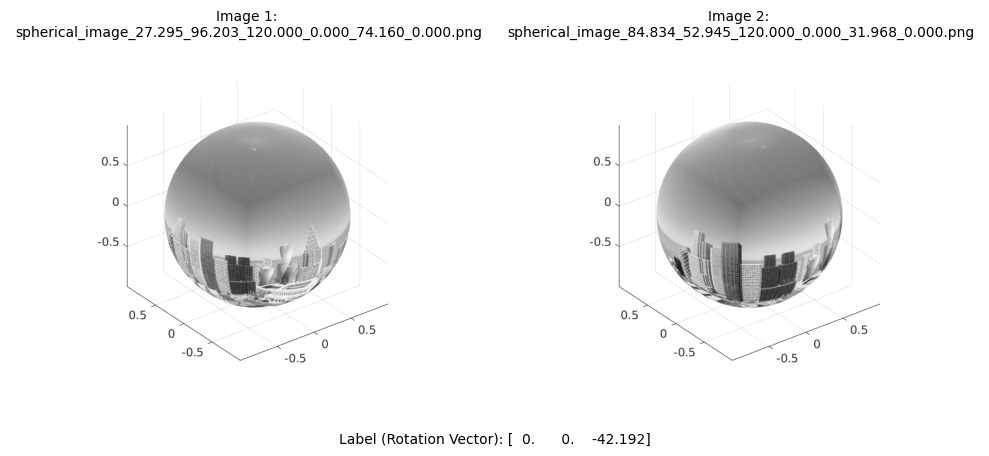

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



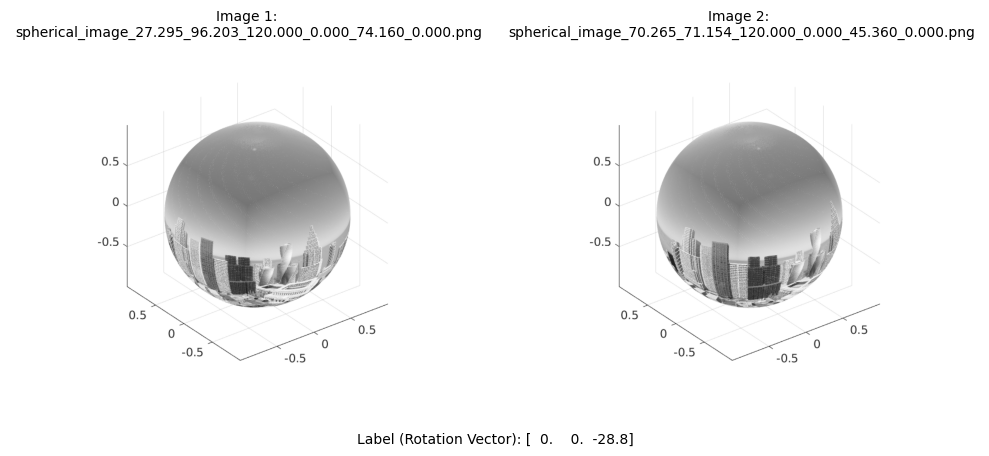

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



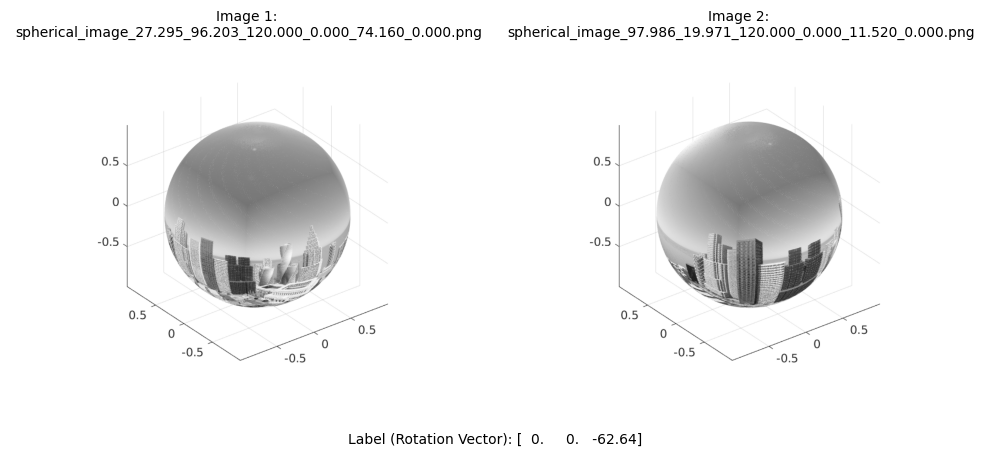

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



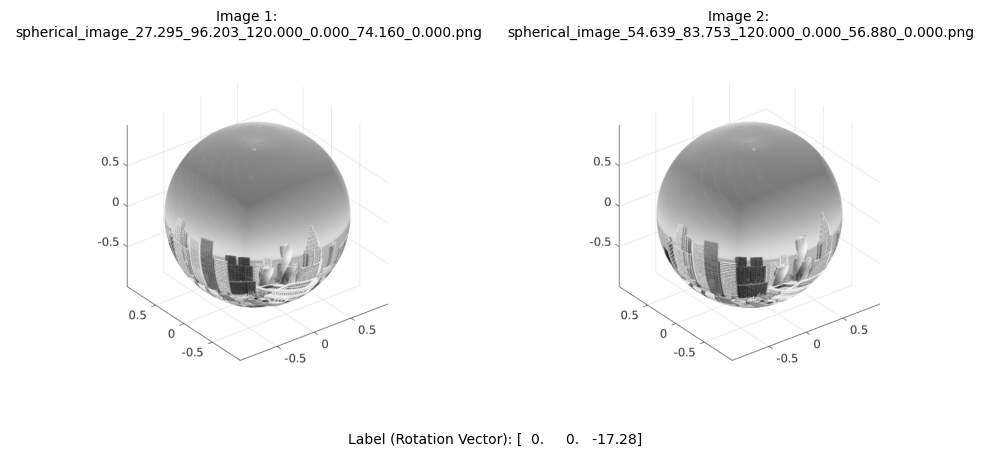

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



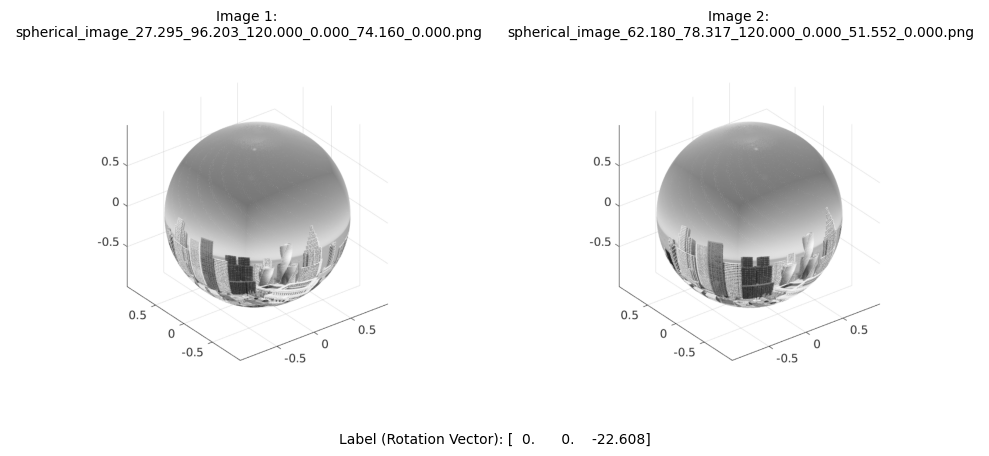

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



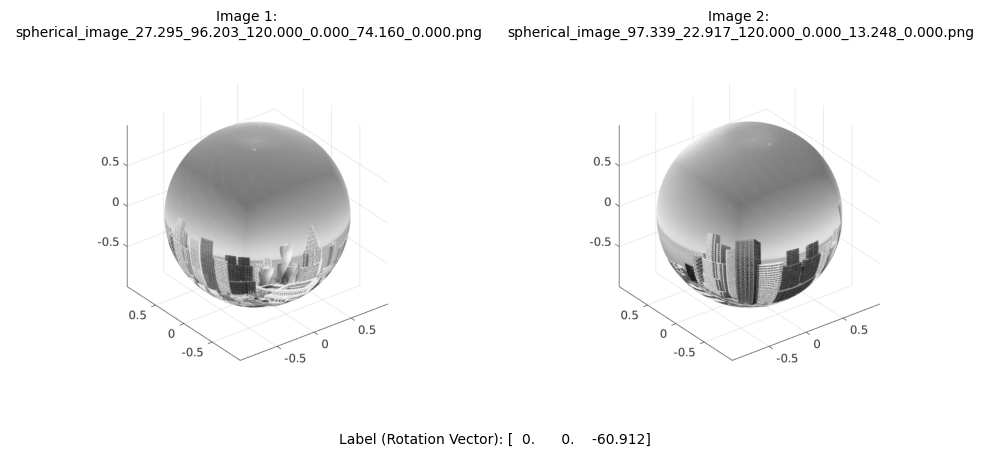

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



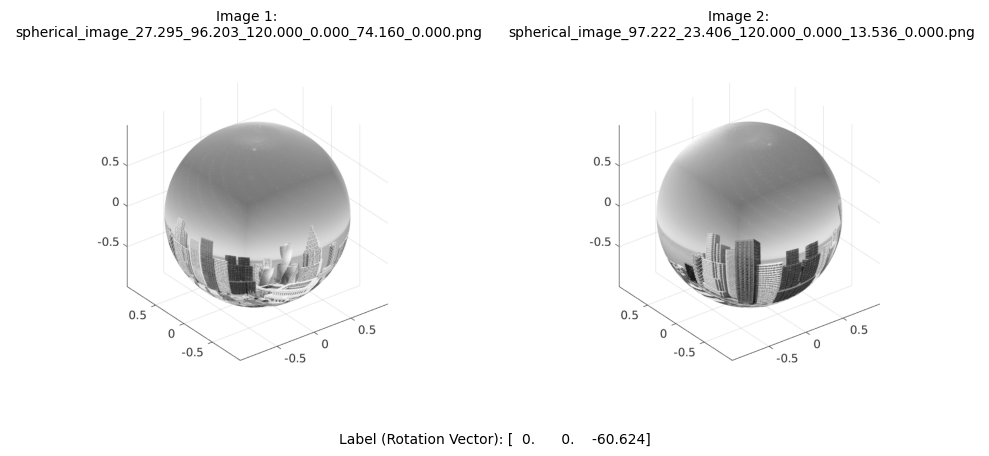

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



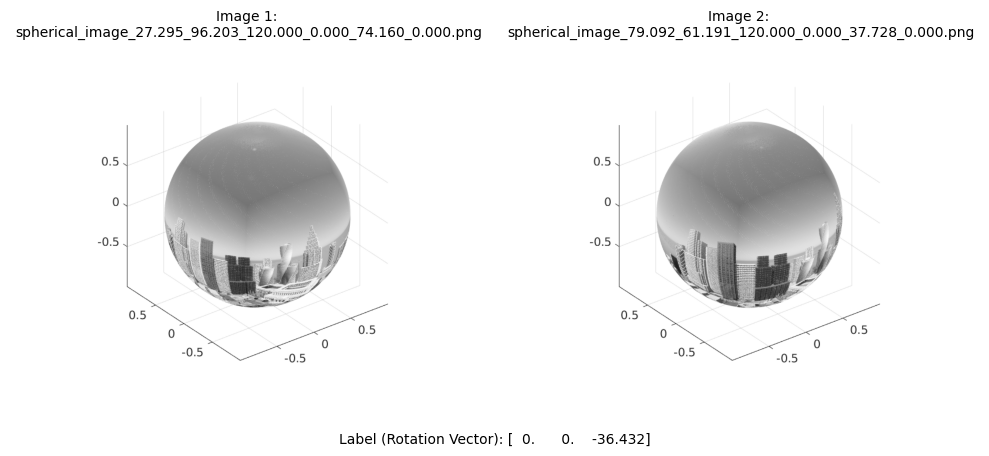

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



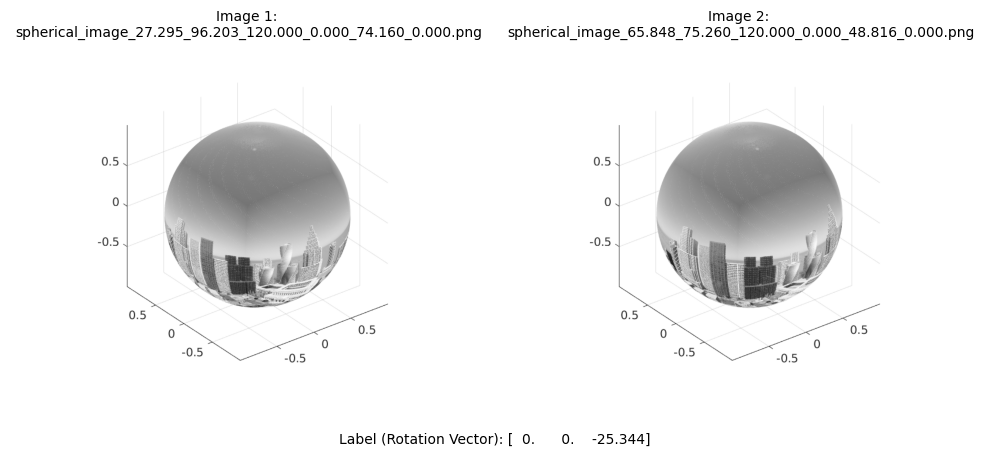

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



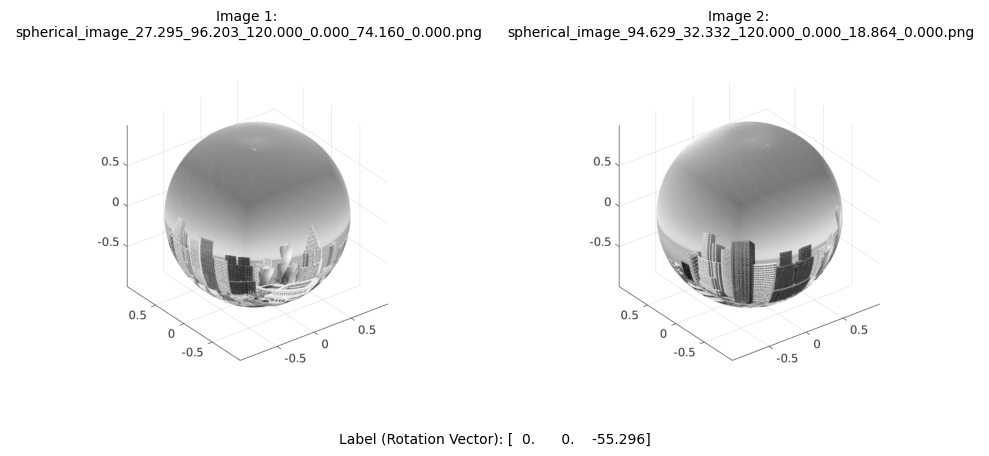

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



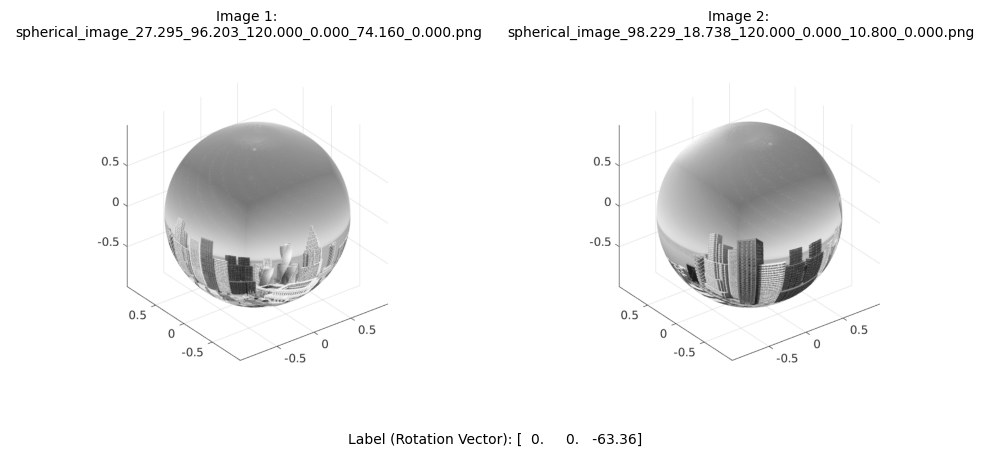

In [4]:
for i in range(20): 
    img1, img2, label = dataset[i]
    print(f"{img1.shape}")  # (width, height)
    print(f"{img2.shape}")  # (width, height)
    print(f" {label.shape if isinstance(label, torch.Tensor) else len(label)}\n")
    
    plot_image_pair_with_label(pairs[i][0], pairs[i][1], label.numpy())

In [ ]:
model = ExtremeRotationEstimator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_function = QuaternionLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Inputs
# batch_size = 8
# img1 = torch.randn(batch_size, 3, 672, 896)  # Example input image 1
# img2 = torch.randn(batch_size, 3, 672, 896)  # Example input image 2
# rotation_query = torch.randn(batch_size, 3)  # Example ground truth quaternion

# # Model
# model = ExtremeRotationEstimator()

# # Forward Pass
# output = model(img1, img2, rotation_query)
# print(output.shape)  # Should be (batch_size, 4)


In [ ]:

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for img1, img2, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(img1, img2,labels, None)
        # print(outputs.shape)
        # print(labels.shape)

        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")


In [ ]:


def train_model(model, dataloader, loss_function, optimizer, device, num_epochs, accumulation_steps=1, use_autocast=True):
    model.to(device)
    scaler = GradScaler() if use_autocast else None  # Initialize GradScaler only if using autocast

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (img1, img2, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
            img1, img2, labels = img1.to(device, non_blocking=True), img2.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # Forward pass with or without mixed precision
            if use_autocast:
                with autocast():
                    outputs = model(img1, img2, labels)
                    loss = loss_function(outputs, labels) / accumulation_steps
            else:
                outputs = model(img1, img2, labels)
                loss = loss_function(outputs, labels) / accumulation_steps

            # Backward pass
            if use_autocast:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            # Gradient accumulation
            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(dataloader):
                if use_autocast:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps

            # Free unused memory explicitly
            del img1, img2, labels, outputs, loss

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader):.4f}")
        torch.cuda.empty_cache()  # Free GPU memory after each epoch



In [ ]:
train_model(
    model=model,
    dataloader=train_loader,  # Replace with your DataLoader
    loss_function=loss_function,
    optimizer=optimizer,
    device=device,
    num_epochs=20,
    accumulation_steps=4  # Accumulate gradients over 4 steps
)

In [ ]:
torch.save(model.state_dict(), "extreme_rotation_estimator_weights_new_loss.pth")
print("Model weights saved successfully.")

In [ ]:
import torch
import numpy as np

def calculate_accuracy(predicted, ground_truth, threshold_degrees=10):
    """
    Calculate accuracy based on angular difference between predicted and ground truth quaternions.
    
    Args:
        predicted (torch.Tensor): Predicted quaternions, shape (batch_size, 4).
        ground_truth (torch.Tensor): Ground truth quaternions, shape (batch_size, 4).
        threshold_degrees (float): Threshold for accuracy in degrees.
        
    Returns:
        float: Accuracy percentage.
    """
    predicted = predicted / torch.norm(predicted, dim=1, keepdim=True)
    ground_truth = ground_truth / torch.norm(ground_truth, dim=1, keepdim=True)
    
    dot_product = torch.sum(predicted * ground_truth, dim=1).clamp(-1.0, 1.0)  # Clamp to avoid numerical issues
    angles = 2 * torch.acos(torch.abs(dot_product))  # Angular difference in radians
    
    angles_degrees = angles * (180.0 / np.pi)
    
    correct_predictions = (angles_degrees <= threshold_degrees).float()
    accuracy = correct_predictions.mean().item() * 100  # Percentage
    
    return accuracy


In [ ]:
model = ExtremeRotationEstimator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("extreme_rotation_estimator_weights.pth", map_location=device))  # Load weights


model.to(device)  # Move to the specified device
model.eval()

In [ ]:

def compute_geodesic_error(predicted_quaternions, ground_truth_quaternions):

    predicted_quaternions = predicted_quaternions / torch.norm(predicted_quaternions, dim=1, keepdim=True)
    ground_truth_quaternions = ground_truth_quaternions / torch.norm(ground_truth_quaternions, dim=1, keepdim=True)
    
    # Compute the dot product (cosine of the angle)
    dot_product = torch.abs(torch.sum(predicted_quaternions * ground_truth_quaternions, dim=1))
    
    # Clamp the dot product to avoid numerical issues
    dot_product = torch.clamp(dot_product, -1.0, 1.0)
    
    # Compute the geodesic error (in degrees)
    geodesic_error = 2 * torch.acos(dot_product) * (180.0 / torch.pi)
    return geodesic_error

def evaluate_geodesic_error(model, dataloader, device, threshold_degrees=5):

    model.eval()
    all_errors = []

    with torch.no_grad():
        for batch in dataloader:
            # Extract inputs and ground truth
            img1, img2, ground_truth_quaternions = batch
            img1, img2, ground_truth_quaternions = img1.to(device), img2.to(device), ground_truth_quaternions.to(device)
            
            # Generate a placeholder rotation query
            rotation_query = torch.zeros(img1.size(0), 3, device=device)
            # Forward pass
            predicted_quaternions = model(img1, img2, rotation_query)
            print(predicted_quaternions,rotation_query)
            # Compute geodesic errors for this batch
            errors = compute_geodesic_error(predicted_quaternions, ground_truth_quaternions)
            all_errors.append(errors)

    # Concatenate errors from all batches
    all_errors = torch.cat(all_errors).cpu().numpy()
    
    # Compute metrics
    mean_error = all_errors.mean()
    median_error = np.median(all_errors)
    accuracy = (all_errors < threshold_degrees).mean() * 100  # Percentage
    
    return {
        "mean_geodesic_error": mean_error,
        "median_geodesic_error": median_error,
        "accuracy_below_threshold": accuracy
    }

threshold_degrees = 5

# # Evaluate on validation/test set
# metrics = evaluate_geodesic_error(model, val_loader, device, threshold_degrees=5)
# print(f"Mean Geodesic Error: {metrics['mean_geodesic_error']:.2f}°")
# print(f"Median Geodesic Error: {metrics['median_geodesic_error']:.2f}°")
# print(f"{threshold_degrees}° Accuracy: {metrics['accuracy_below_threshold']:.2f}%")


In [ ]:
# dataset = SphericalImageRotationDataset(pairs[0], labels[0])
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [ ]:
# dataset

In [ ]:
# for batch in dataloader:
#     # Extract inputs and ground truth
#     img1, img2, ground_truth_quaternions = batch
#     img1, img2, ground_truth_quaternions = img1.to(device), img2.to(device), ground_truth_quaternions.to(device)
    
#     # Generate a placeholder rotation query
#     rotation_query = torch.zeros(img1.size(0), 3, device=device)
#     # Forward pass
#     predicted_quaternions = model(img1, img2, rotation_query)

In [ ]:
image_dir = "SphericalImages2" 
image_paths = glob.glob(os.path.join(image_dir, "*.png"))

pairs, labels = generate_pairs_with_labels(image_paths[14:16])
dataset = SphericalImageRotationDataset(pairs, labels)

In [ ]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [ ]:
model.eval()
all_errors = []

with torch.no_grad():
    for batch in dataloader:
        img1, img2, ground_truth_quaternions = batch
        img1, img2, ground_truth_quaternions = img1.to(device), img2.to(device), ground_truth_quaternions.to(device)
        predicted_quaternions = model(img1, img2, ground_truth_quaternions)
        print(predicted_quaternions,ground_truth_quaternions)
        errors = compute_geodesic_error(predicted_quaternions, ground_truth_quaternions)
        all_errors.append(errors)

In [ ]:
errors